# EDA 
1. General plots of demographics -> breakdown by republican and democrats?
2. Maybe some plots on which county switched from D -> R or R-> D
4. Get updated demographics for 2020?

Classes needed for EDA? Unlikely
Function for calculating electoral college votes. pd.merge on state?
One hot encoder to prep

In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from src import explorers

# For choropleth plots
from urllib.request import urlopen
import json

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Load data and put fips as string
pd.set_option("display.max_columns", 40)
data = pd.read_csv('data/cleaned_data.csv', dtype={'fips': str})
population_data = pd.read_csv('data/population.csv')

# Drop the extra column in dataframe
data.drop(columns='Unnamed: 0', inplace=True)
data.head()

,state,county,fips,white_pct,black_pct,hispanic_pct,nonwhite_pct,foreignborn_pct,female_pct,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,trump16_pct,clinton16_pct,otherpres16_pct,romney12_pct,obama12_pct,otherpres12_pct,cvap_pct12,metro,rural,urban_metroadj,urban_not_metroadj
0,Alabama,Autauga,1001,75.683482,18.370906,2.572254,24.316518,1.838362,51.176225,40.037058,13.978456,53099.0,5.591657,12.417046,75.407229,10.002112,74.065601,42.002162,72.766588,23.769671,3.463741,72.618252,26.587832,0.793916,58.815434,1,0,0,0
1,Alabama,Baldwin,1003,83.178788,9.225603,4.366698,16.821212,3.269510,51.194928,35.474412,18.714851,51365.0,6.286843,9.972418,70.452889,7.842227,68.405607,42.279099,76.545712,19.385601,4.068687,77.358269,21.589444,1.052286,56.228504,1,0,0,0
2,Alabama,Barbour,1005,45.885624,47.888329,4.309762,54.114376,2.859397,46.498084,37.664387,16.528895,33956.0,12.824738,26.235928,87.132213,19.579752,81.364746,67.789635,52.096666,46.527844,1.375490,48.223130,51.368494,0.408376,56.485890,0,0,1,0
3,Alabama,Bibb,1007,74.765196,21.212121,2.223994,25.234804,1.351232,46.464646,37.329435,14.885699,39776.0,7.146827,19.301587,88.000000,15.020490,87.471774,68.352607,76.403220,21.249575,2.347205,72.826603,26.152019,1.021378,47.868107,1,0,0,0
4,Alabama,Blount,1009,87.657701,1.557951,8.727298,12.342299,4.271801,50.485235,37.240053,17.192916,46212.0,5.953833,19.968585,86.950243,16.643368,86.163610,89.951502,89.334844,8.425825,2.239331,86.465884,12.371907,1.162209,56.577893,1,0,0,0


## State Level Statistics


In [45]:
# Let's look at some state level statistics -> come back to this later
data_not_clean = pd.read_csv('data/election-context-2018.csv')
agg = data_not_clean.groupby('state').agg(
    trump16 = pd.NamedAgg(column='trump16', aggfunc=sum),
    clinton16 = pd.NamedAgg(column='clinton16', aggfunc=sum),
    otherpres16 = pd.NamedAgg(column='otherpres16', aggfunc=sum),
    female_pct = pd.NamedAgg(column='female_pct', aggfunc=np.mean),
)

In [46]:
data_not_clean['total_votes'] = data_not_clean['trump16'] + data_not_clean['clinton16'] + data_not_clean['otherpres16']

## County Breakdown

In [47]:
# First, which counties went most strongly for trump or clinton?
columns_of_interest = ['state', 'county', 'white_pct', 
                       'trump16_pct', 'clinton16_pct', 'otherpres16_pct']
data[columns_of_interest].sort_values(by='otherpres16_pct', ascending=False)

,state,county,white_pct,trump16_pct,clinton16_pct,otherpres16_pct
71,Arizona,Graham,51.461536,39.520339,16.256279,44.223382
72,Arizona,Greenlee,47.777537,36.440678,21.032357,42.526965
70,Arizona,Gila,63.222325,38.646211,19.083304,42.270485
2748,Utah,Cache,83.935905,45.798037,18.551899,35.650064
553,Idaho,Madison,89.494674,56.992606,7.655533,35.351861
...,...,...,...,...,...,...
31,Alabama,Greene,17.142192,17.172131,82.233607,0.594262
1381,Mississippi,Claiborne,12.618091,12.640449,86.797753,0.561798
3055,Wisconsin,Menominee,9.086830,21.032056,78.420641,0.547303
1422,Mississippi,Noxubee,26.338079,21.528525,77.987083,0.484392


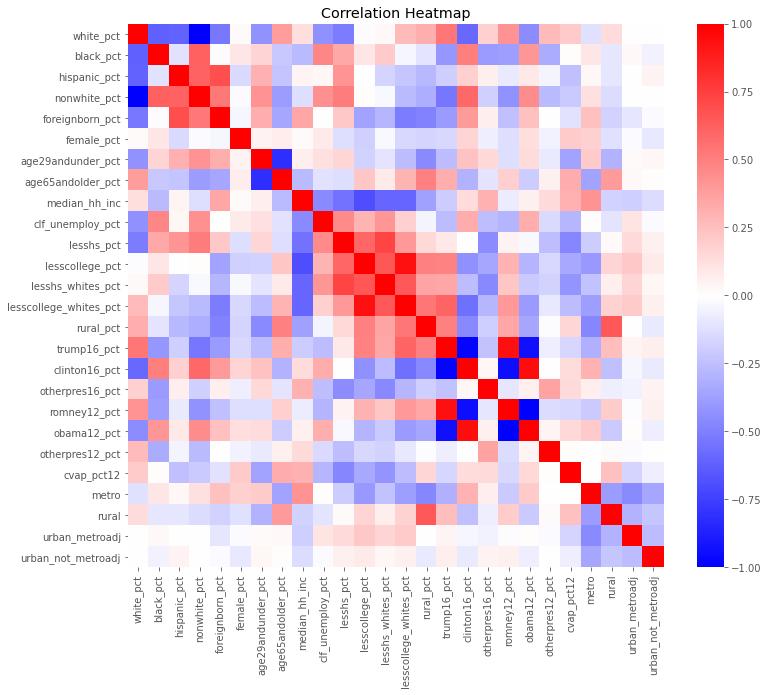

In [48]:
# Let's look at some correlations in the data
plt.figure(figsize=(12,10))
sns.heatmap(data[data.columns[3:]].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.savefig('images/corr_heatmap.png', bbox_inches='tight', dpi=350)

In [49]:
# Drop some of the redundant columns
columns_to_drop = ['nonwhite_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct']
data.drop(columns=columns_to_drop, inplace=True)
data.to_csv('data/cleaned_data2.csv')

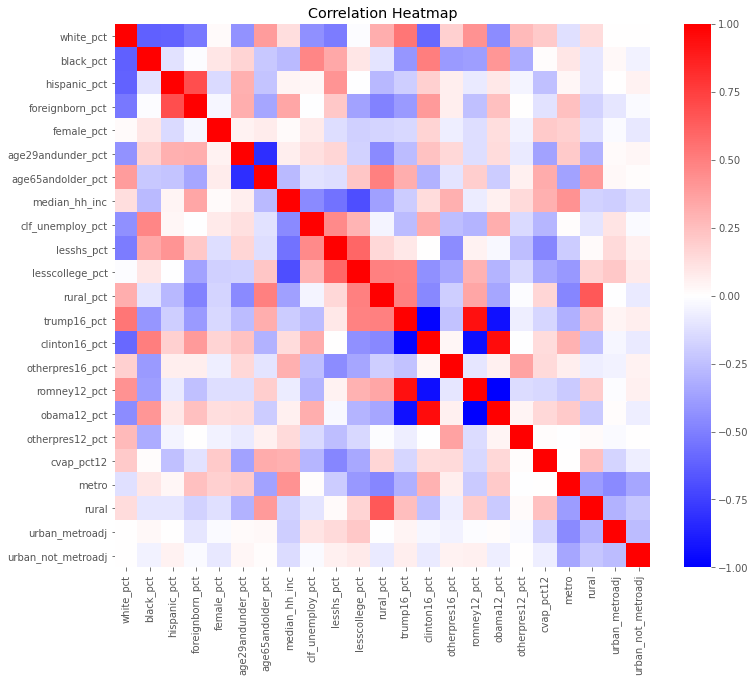

In [50]:
# Redo heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data[data.columns[3:]].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.savefig('images/corr_heatmap2.png', bbox_inches='tight', dpi=350)

## Manipulations for better visuals
To make some of the manipulations better, breaking down into: trump, clinton, other

In [51]:
trump_idx, clinton_idx, other_idx = explorers.get_idx(data, 'trump16_pct', 'clinton16_pct', 'otherpres16_pct')
data['county'][trump_idx]

0          Autauga
1          Baldwin
2          Barbour
3             Bibb
4           Blount
           ...    
3105      Sublette
3106    Sweetwater
3108         Uinta
3109      Washakie
3110        Weston
Name: county, Length: 2620, dtype: object

In [85]:
colnames = ['Trump', 'Clinton']

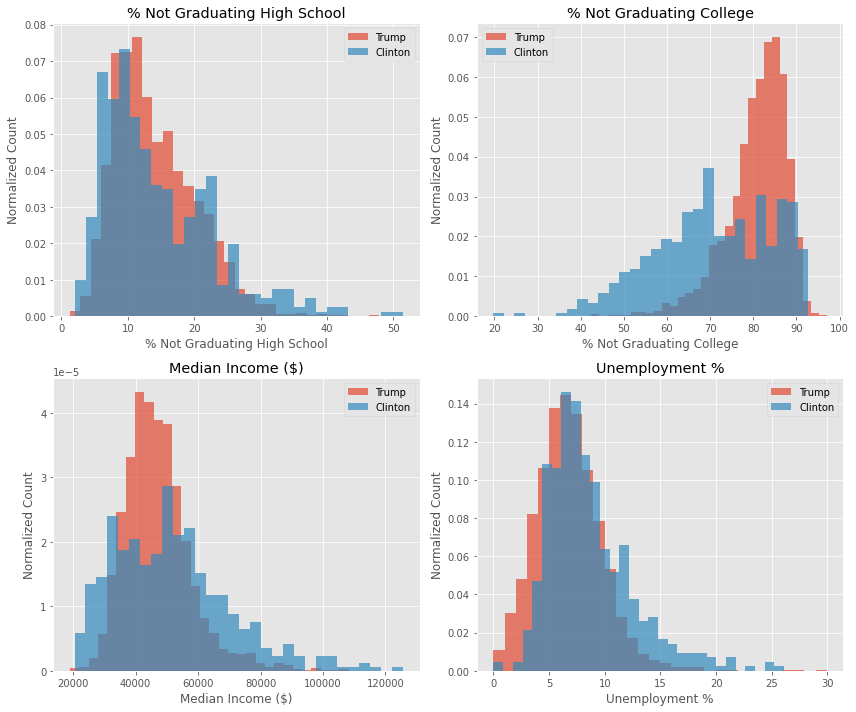

In [84]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[0,0], 'lesshs_pct', idx, pres, '% Not Graduating High School')
    
for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[0,1], 'lesscollege_pct', idx, pres, '% Not Graduating College')

for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[1,0], 'median_hh_inc', idx, pres, 'Median Income ($)')
    
for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[1,1], 'clf_unemploy_pct', idx, pres, 'Unemployment %')    
    
fig.tight_layout()
plt.savefig('images/income_unemploy.png', dpi=250)

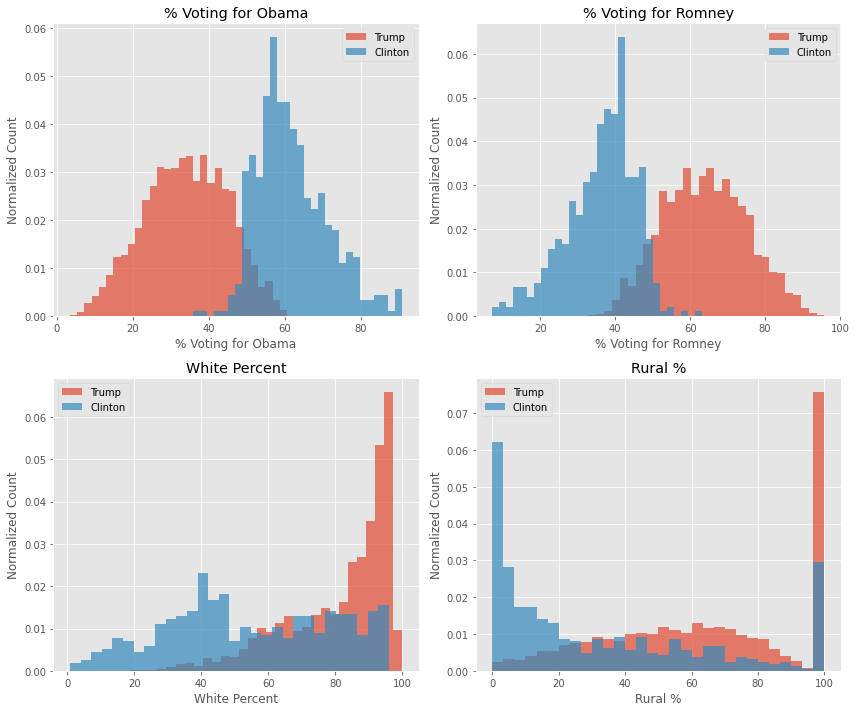

In [91]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[0,0], 'obama12_pct', idx, pres, '% Voting for Obama')
    
for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[0,1], 'romney12_pct', idx, pres, '% Voting for Romney')
        
for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[1,0], 'white_pct', idx, pres, 'White Percent')
    
for pres, idx in zip(colnames, [trump_idx, clinton_idx]):
    explorers.make_histogram(data, axes[1,1], 'rural_pct', idx, pres, 'Rural %')
fig.tight_layout()
plt.savefig('images/prev_election.png', dpi=250)

In [ ]:
# Pie charts!
data[data['white_pct'] >= 90].agg("count")

In [ ]:
data.head()

In [ ]:
pop = pd.read_csv('data/population.csv')
pop.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
pop['electoral_votes'] = pd.Series(np.zeros(pop.shape[0]))

In [57]:
states = ['California']
for state in states:
    pop.loc[pop['state'] == state,'electoral_votes'] = 55

In [58]:
electoral = pop.groupby(by='state').mean()

In [59]:
electoral.to_csv('data/electoral.csv')